In [129]:
%matplotlib widget

import warnings
warnings.filterwarnings('ignore')

# Configure logging to suppress INFO messages from SunPy
import logging
logging.getLogger('sunpy').setLevel(logging.WARNING)

from datetime import datetime
from skimage import filters, feature
from skimage.registration import optical_flow_tvl1
import gc
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, FFMpegWriter
import astropy.io.fits as fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import Helioprojective
import sunpy
import sunpy.map
from skimage.transform import resize
from sunkit_instruments import suvi
from aiapy.calibrate import register, update_pointing
from scipy import stats
import sunpy.sun.constants as const
import matplotlib.colors as colors
from astropy.visualization import ImageNormalize, SqrtStretch, LogStretch, PercentileInterval
from scipy import ndimage
import sunkit_image.enhance as enhance
from tqdm import tqdm

import os
import sys
# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
if script_path not in sys.path:
    sys.path.append(script_path)

import importlib
import solar_data_utils as myfuncs
# Reload to update with new changes
importlib.reload(myfuncs)

plt.rcParams['figure.figsize'] = [7,7]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

data_dir = '/home/mnedal/data'
savedir = '/home/mnedal/repos/dias_work'

os.makedirs(f'{data_dir}/png/aia/131A/runratio', exist_ok=True)
os.makedirs(f'{data_dir}/png/aia/171A/runratio', exist_ok=True)
os.makedirs(f'{data_dir}/png/aia/193A/runratio', exist_ok=True)
os.makedirs(f'{data_dir}/png/aia/211A/runratio', exist_ok=True)

In [9]:
import sunpy
sunpy.__version__

'5.1.0'

In [220]:
start = '2024-05-14T17:00:00'
end   = '2024-05-14T18:59:00'
channel = 304
data_type = 'highres'

# Check if the datetime is a string
if isinstance(start, str) and isinstance(end, str):
    dt_dict = myfuncs.split_datetime(start=start, end=end)

# Check if the datetime is a pandas.Timestamp
elif isinstance(start, pd.Timestamp) and isinstance(end, pd.Timestamp):
    dt_dict = myfuncs.split_datetime(start=str(start).replace(' ','T'), end=str(end).replace(' ','T'))

data_path = f'{data_dir}/AIA/{channel}A/{data_type}/lv15'
data = sorted(glob.glob(f'{data_path}/aia*{channel}A_*.fits'))

start_pattern = f"aia*{channel}A_{dt_dict['start_year']}_{dt_dict['start_month']}_{dt_dict['start_day']}T{dt_dict['start_hour']}_{dt_dict['start_minute']}*"
end_pattern   = f"aia*{channel}A_{dt_dict['end_year']}_{dt_dict['end_month']}_{dt_dict['end_day']}T{dt_dict['end_hour']}_{dt_dict['end_minute']}*"

first_file_to_find = sorted(glob.glob(f'{data_path}/{start_pattern}*.fits'))
last_file_to_find  = sorted(glob.glob(f'{data_path}/{end_pattern}*.fits'))

idx1 = data.index(first_file_to_find[0])
idx2 = data.index(last_file_to_find[0])

chosen_files = data[idx1:idx2]

map_objects = []
for i, file in enumerate(chosen_files):
    # load the file as a sunpy map
    m = sunpy.map.Map(file)
    print(f'AIA {channel}A image {i} is loaded')
    map_objects.append(m)
    print(f'Append lv1.5 AIA {channel} map {i}')

AIA 304A image 0 is loaded
Append lv1.5 AIA 304 map 0
AIA 304A image 1 is loaded
Append lv1.5 AIA 304 map 1
AIA 304A image 2 is loaded
Append lv1.5 AIA 304 map 2
AIA 304A image 3 is loaded
Append lv1.5 AIA 304 map 3
AIA 304A image 4 is loaded
Append lv1.5 AIA 304 map 4
AIA 304A image 5 is loaded
Append lv1.5 AIA 304 map 5
AIA 304A image 6 is loaded
Append lv1.5 AIA 304 map 6
AIA 304A image 7 is loaded
Append lv1.5 AIA 304 map 7
AIA 304A image 8 is loaded
Append lv1.5 AIA 304 map 8
AIA 304A image 9 is loaded
Append lv1.5 AIA 304 map 9
AIA 304A image 10 is loaded
Append lv1.5 AIA 304 map 10
AIA 304A image 11 is loaded
Append lv1.5 AIA 304 map 11
AIA 304A image 12 is loaded
Append lv1.5 AIA 304 map 12
AIA 304A image 13 is loaded
Append lv1.5 AIA 304 map 13
AIA 304A image 14 is loaded
Append lv1.5 AIA 304 map 14
AIA 304A image 15 is loaded
Append lv1.5 AIA 304 map 15
AIA 304A image 16 is loaded
Append lv1.5 AIA 304 map 16
AIA 304A image 17 is loaded
Append lv1.5 AIA 304 map 17
AIA 304A ima

In [221]:
len(map_objects)

592

In [222]:
aia_304_map_objects = map_objects

## Load AIA maps

In [179]:
start_time = '2024-05-14T17:00:00'
end_time   = '2024-05-14T18:59:00'

# aia_131_map_objects = load_aia(start=start_time, end=end_time, channel=131)
# aia_171_map_objects = load_aia(start=start_time, end=end_time, channel=171)
aia_193_map_objects = myfuncs.load_aia(start=start_time, end=end_time, channel=304)
# aia_211_map_objects = load_aia(start=start_time, end=end_time, channel=211)

IndexError: list index out of range

In [51]:
# Temp solution
filenames = sorted(glob.glob(f'{data_dir}/AIA/{channel}A/{data_type}/lv15/*.fits'))
for i, file in enumerate(filenames):
    if file.split('/')[-1].startswith('aia_lev15_193a'):
        filenames[i] = f'{data_dir}/AIA/{channel}A/{data_type}/lv15/' + filenames[i].split('/')[-1].replace('aia_lev15_193a', 'aia.lev15.193A').replace('t', 'T')
        filenames[i] = filenames[i].replace('.fiTs', '.fits')
        
sorted(filenames)

['/home/mnedal/data/AIA/193A/highres/lv15/aia.lev15.193A_2024_05_14T17_00_07_22z_image_lev15.fits',
 '/home/mnedal/data/AIA/193A/highres/lv15/aia.lev15.193A_2024_05_14T17_00_16_84z_image_lev15.fits',
 '/home/mnedal/data/AIA/193A/highres/lv15/aia.lev15.193A_2024_05_14T17_00_31_08z_image_lev15.fits',
 '/home/mnedal/data/AIA/193A/highres/lv15/aia.lev15.193A_2024_05_14T17_00_40_84z_image_lev15.fits',
 '/home/mnedal/data/AIA/193A/highres/lv15/aia.lev15.193A_2024_05_14T17_00_54_92z_image_lev15.fits',
 '/home/mnedal/data/AIA/193A/highres/lv15/aia.lev15.193A_2024_05_14T17_01_04_84z_image_lev15.fits',
 '/home/mnedal/data/AIA/193A/highres/lv15/aia.lev15.193A_2024_05_14T17_01_28_85z_image_lev15.fits',
 '/home/mnedal/data/AIA/193A/highres/lv15/aia.lev15.193A_2024_05_14T17_01_42_63z_image_lev15.fits',
 '/home/mnedal/data/AIA/193A/highres/lv15/aia.lev15.193A_2024_05_14T17_01_52_84z_image_lev15.fits',
 '/home/mnedal/data/AIA/193A/highres/lv15/aia.lev15.193A_2024_05_14T17_02_07_50z_image_lev15.fits',


In [78]:
new_name

'/home/mnedal/data/AIA/193A/highres/lv15/aia.lev15.193A_2024_05_14T18_59_52_84z_image_lev15.fits'

In [79]:
old_name.split('/')[-1].split(f'{channel}a_')[-1].split('_image')[0]

'2024_05_14t18_59_52_84z'

In [80]:
# Rename the original files
old_filenames = sorted(glob.glob(f'{data_dir}/AIA/{channel}A/{data_type}/lv15/*.fits'))
new_filenames = filenames
directory = f'{data_dir}/AIA/{channel}A/{data_type}/lv15'

# Match and rename files based on a common substring
for old_name in old_filenames:
    # Extract a common identifier, for example, the part before the underscore
    identifier = old_name.split('/')[-1].split(f'{channel}a_')[-1].split('_image')[0].replace('t','T')

    # Find the corresponding new filename
    for new_name in new_filenames:
        if identifier in new_name:
            try:
                os.rename(old_name, new_name)
                print(f"Renamed: {old_name} -> {new_name}")
            except FileNotFoundError:
                print(f"Error: {old_name} not found.")
            except PermissionError:
                print(f"Error: Permission denied for {old_name}.")
            except Exception as e:
                print(f"An unexpected error occurred: {e}")
            break

Renamed: /home/mnedal/data/AIA/193A/highres/lv15/aia_lev15_193a_2024_05_14t17_00_07_22z_image_lev15.fits -> /home/mnedal/data/AIA/193A/highres/lv15/aia.lev15.193A_2024_05_14T17_00_07_22z_image_lev15.fits
Renamed: /home/mnedal/data/AIA/193A/highres/lv15/aia_lev15_193a_2024_05_14t17_00_16_84z_image_lev15.fits -> /home/mnedal/data/AIA/193A/highres/lv15/aia.lev15.193A_2024_05_14T17_00_16_84z_image_lev15.fits
Renamed: /home/mnedal/data/AIA/193A/highres/lv15/aia_lev15_193a_2024_05_14t17_00_31_08z_image_lev15.fits -> /home/mnedal/data/AIA/193A/highres/lv15/aia.lev15.193A_2024_05_14T17_00_31_08z_image_lev15.fits
Renamed: /home/mnedal/data/AIA/193A/highres/lv15/aia_lev15_193a_2024_05_14t17_00_40_84z_image_lev15.fits -> /home/mnedal/data/AIA/193A/highres/lv15/aia.lev15.193A_2024_05_14T17_00_40_84z_image_lev15.fits
Renamed: /home/mnedal/data/AIA/193A/highres/lv15/aia_lev15_193a_2024_05_14t17_00_54_92z_image_lev15.fits -> /home/mnedal/data/AIA/193A/highres/lv15/aia.lev15.193A_2024_05_14T17_00_54_9

In [82]:
# Import the renamed files
filenames = sorted(glob.glob(f'{data_dir}/AIA/{channel}A/{data_type}/lv15/*.fits'))
len(filenames)

802

In [83]:
aia_193_map_objects = [sunpy.map.Map(m) for m in filenames]

In [84]:
len(aia_193_map_objects)

802

In [223]:
# for m in aia_131_map_objects:
#     m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=2e3, stretch=LogStretch())
#     # m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5e2, stretch=SqrtStretch())

# for m in aia_171_map_objects:
#     m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=4e3, stretch=LogStretch())
#     # m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=4e3, stretch=SqrtStretch())

# for m in aia_193_map_objects:
#     m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5e3, stretch=LogStretch())

for m in aia_304_map_objects:
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5e2, stretch=SqrtStretch())
    # m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=7e2, stretch=LogStretch())

# for m in aia_211_map_objects:
#     m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=4e3, stretch=LogStretch())
#     # m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=4e3, stretch=SqrtStretch())

## Load SUVI maps

In [ ]:
suvi_131_map_objects = load_suvi(start='2024-05-14T17:00:00', end='2024-05-14T19:00:00', channel=131)
suvi_171_map_objects = load_suvi(start='2024-05-14T17:00:00', end='2024-05-14T19:00:00', channel=171)
suvi_195_map_objects = load_suvi(start='2024-05-14T17:00:00', end='2024-05-14T19:00:00', channel=195)
suvi_284_map_objects = load_suvi(start='2024-05-14T17:00:00', end='2024-05-14T19:00:00', channel=284)

## Show the maps

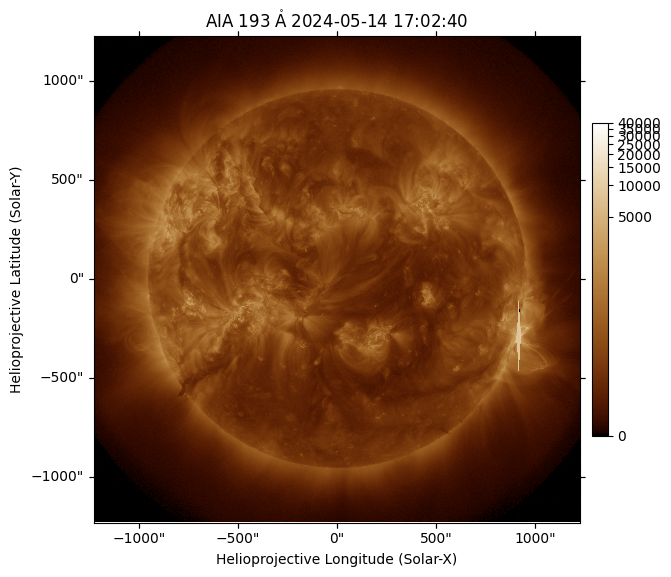

In [87]:
idx = 12
aia193 = aia_193_map_objects[idx]

fig = plt.figure(figsize=[7,7])

ax = fig.add_subplot(111, projection=aia193)
img = aia193.plot(axes=ax)
plt.colorbar(img, shrink=0.5, pad=0.02)
ax.grid(False)
fig.tight_layout()
plt.show()

In [ ]:
idx = 35
aia131 = aia_131_map_objects[idx]
aia171 = aia_171_map_objects[idx]
aia193 = aia_193_map_objects[idx]
aia211 = aia_211_map_objects[idx]

fig = plt.figure(figsize=[20,5])

ax = fig.add_subplot(141, projection=aia131)
img = aia131.plot(axes=ax)
plt.colorbar(img, shrink=0.5, pad=0.02)
ax.grid(False)

ax = fig.add_subplot(142, projection=aia171)
img = aia171.plot(axes=ax)
plt.colorbar(img, shrink=0.5, pad=0.02)
ax.grid(False)

ax = fig.add_subplot(143, projection=aia193)
img = aia193.plot(axes=ax)
plt.colorbar(img, shrink=0.5, pad=0.02)
ax.grid(False)

ax = fig.add_subplot(144, projection=aia211)
img = aia211.plot(axes=ax)
plt.colorbar(img, shrink=0.5, pad=0.02)
ax.grid(False)

fig.tight_layout()
plt.show()




idx = 12
suvi131 = suvi_131_map_objects[idx]
suvi171 = suvi_171_map_objects[idx]
suvi195 = suvi_195_map_objects[idx]
suvi284 = suvi_284_map_objects[idx]

fig = plt.figure(figsize=[20,5])

ax = fig.add_subplot(141, projection=suvi131)
img = suvi131.plot(axes=ax)
plt.colorbar(img, shrink=0.5, pad=0.02)
ax.grid(False)

ax = fig.add_subplot(142, projection=suvi171)
img = suvi171.plot(axes=ax)
plt.colorbar(img, shrink=0.5, pad=0.02)
ax.grid(False)

ax = fig.add_subplot(143, projection=suvi195)
img = suvi195.plot(axes=ax)
plt.colorbar(img, shrink=0.5, pad=0.02)
ax.grid(False)

ax = fig.add_subplot(144, projection=suvi284)
img = suvi284.plot(axes=ax)
plt.colorbar(img, shrink=0.5, pad=0.02)
ax.grid(False)

fig.tight_layout()
plt.show()

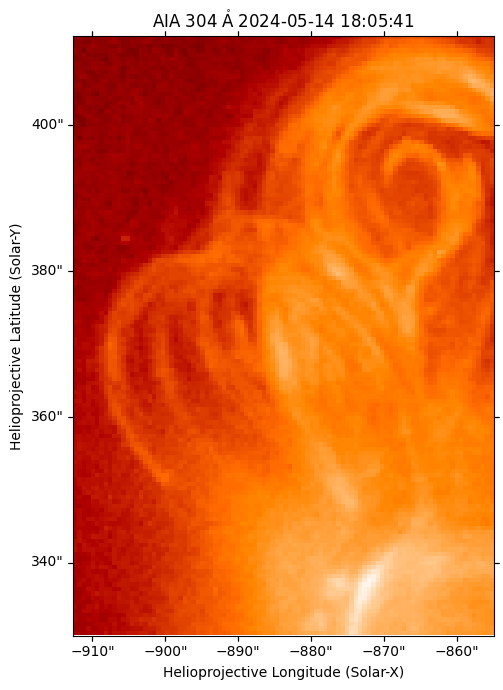

In [196]:
idx = 172

# m = aia_131_map_objects[idx]
# m = aia_171_map_objects[idx]
m = aia_304_map_objects[idx]
# m = aia_211_map_objects[idx]

top_right   = SkyCoord(-855*u.arcsec, 330*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-912*u.arcsec, 412*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)

fig = plt.figure()
ax = fig.add_subplot(projection=m_submap)
m_submap.plot(axes=ax)
ax.grid(False)
fig.tight_layout()
plt.show()

### Crop the ragion of interest

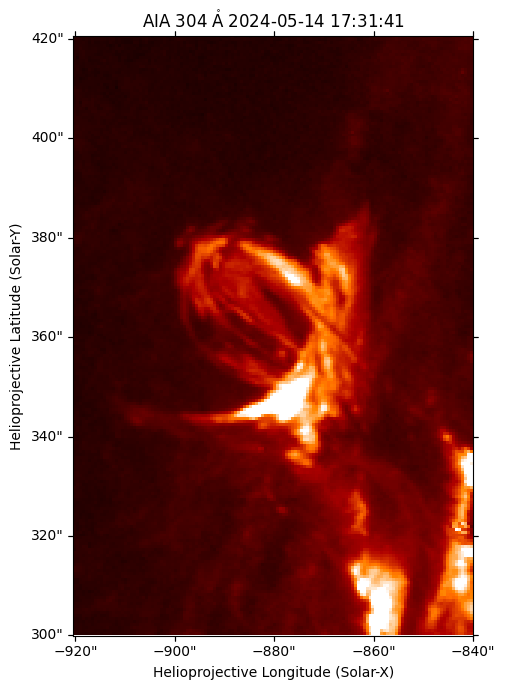

In [218]:
idx = 3
aia193 = aia_304_map_objects[idx]

# top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=aia193.coordinate_frame)
# bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=aia193.coordinate_frame)

top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=aia193.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=aia193.coordinate_frame)
aia193_submap = aia193.submap(bottom_left, top_right=top_right)

fig = plt.figure()
ax = fig.add_subplot(projection=aia193_submap)
aia193_submap.plot(axes=ax)
ax.grid(False)
fig.tight_layout()
plt.show()

In [224]:
# Export images
import os

os.makedirs(f'{data_dir}/png/aia/{channel}A/{data_type}', exist_ok=True)
print(f'Length of the maps list: {len(aia_304_map_objects)}\n')

for i, m in enumerate(aia_304_map_objects):
    top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
    bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
    submap = m.submap(bottom_left, top_right=top_right)

    fig = plt.figure()
    ax = fig.add_subplot(projection=submap)
    submap.plot(axes=ax)
    ax.grid(False)
    fig.tight_layout()
    fig.savefig(f"{data_dir}/png/aia/{channel}A/{data_type}/AIA{channel}_{submap.meta['t_rec']}.png",
                format='png', dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Image {i} at {submap.meta['t_rec']} is done")

Length of the maps list: 592

Image 0 at 2024-05-14T17:00:07Z is done
Image 1 at 2024-05-14T17:00:19Z is done
Image 2 at 2024-05-14T17:00:31Z is done
Image 3 at 2024-05-14T17:00:43Z is done
Image 4 at 2024-05-14T17:00:55Z is done
Image 5 at 2024-05-14T17:01:07Z is done
Image 6 at 2024-05-14T17:01:19Z is done
Image 7 at 2024-05-14T17:01:31Z is done
Image 8 at 2024-05-14T17:01:43Z is done
Image 9 at 2024-05-14T17:01:55Z is done
Image 10 at 2024-05-14T17:02:07Z is done
Image 11 at 2024-05-14T17:02:19Z is done
Image 12 at 2024-05-14T17:02:31Z is done
Image 13 at 2024-05-14T17:02:43Z is done
Image 14 at 2024-05-14T17:02:55Z is done
Image 15 at 2024-05-14T17:03:07Z is done
Image 16 at 2024-05-14T17:03:19Z is done
Image 17 at 2024-05-14T17:03:31Z is done
Image 18 at 2024-05-14T17:03:43Z is done
Image 19 at 2024-05-14T17:03:55Z is done
Image 20 at 2024-05-14T17:04:07Z is done
Image 21 at 2024-05-14T17:04:19Z is done
Image 22 at 2024-05-14T17:04:31Z is done
Image 23 at 2024-05-14T17:04:43Z is d

In [127]:
len(aia_193_map_objects)

802

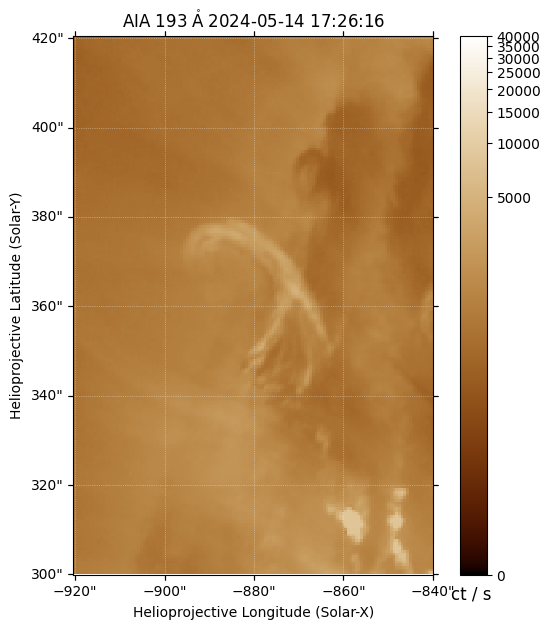

In [138]:
m = aia_193_map_objects[130]
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
submap = m.submap(bottom_left, top_right=top_right)
submap.peek()

In [141]:
m = aia_193_map_objects[130]
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
image1 = m.submap(bottom_left, top_right=top_right)

m = aia_193_map_objects[131]
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
image2 = m.submap(bottom_left, top_right=top_right)

In [142]:
import pyflct

In [145]:
vel_x, vel_y, vm = pyflct.flct(image1.data, image2.data, deltat=12, deltas=1, sigma=2.3)

flct: nominal sliding box size = 8
flct: mean value of gamma^2/sigma^2 = 0.581455

flct: finished


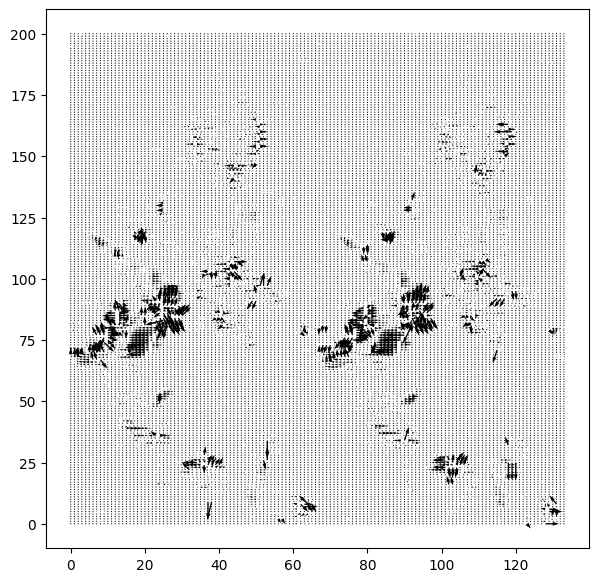

In [176]:
X = np.arange(0, image1.data.shape[1], 1)
Y = np.arange(0, image1.data.shape[0], 1)
U, V = np.meshgrid(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.quiver(U, V, vel_x, vel_y, scale=10)
plt.show()

In [177]:
speed_fclt = np.sqrt(vel_x**2 + vel_y**2)

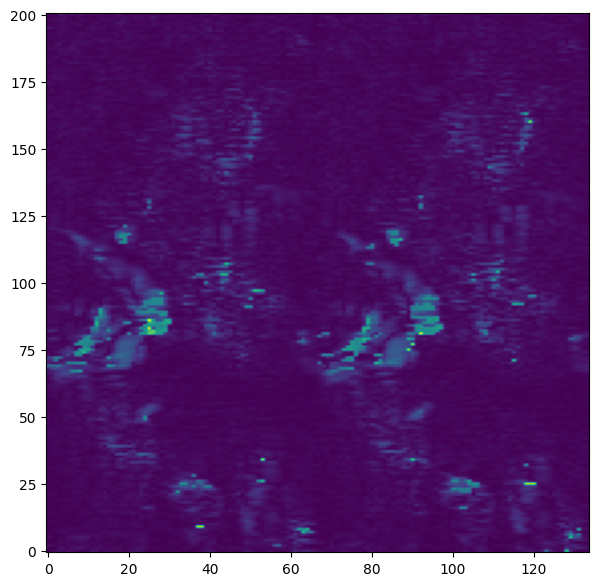

In [178]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(speed_fclt, aspect='auto', origin='lower')
plt.show()

In [ ]:
list_aia193maps = []

for m in aia_193_map_objects:
    # top_right   = SkyCoord(-750*u.arcsec, 430*u.arcsec, frame=m.coordinate_frame)
    # bottom_left = SkyCoord(-970*u.arcsec, 200*u.arcsec, frame=m.coordinate_frame)

    # top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
    # bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
    
    top_right   = SkyCoord(-855*u.arcsec, 330*u.arcsec, frame=m.coordinate_frame)
    bottom_left = SkyCoord(-912*u.arcsec, 412*u.arcsec, frame=m.coordinate_frame)
    
    submap = m.submap(bottom_left, top_right=top_right)
    list_aia193maps.append(submap)

aia193_seq = sunpy.map.Map(list_aia193maps, sequence=True)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=aia193_seq.maps[0])

def update_frame(i):
    """
    Function to update each frame of the animation.
    """
    aia193_seq.maps[i].plot(axes=ax)
    ax.grid(False)

ani = FuncAnimation(fig, update_frame, frames=len(aia193_seq.maps), repeat=False)
fig.tight_layout()
plt.show()

In [ ]:
# Export the frames as PNG images
print(f'Length of the maps list: {len(aia193_seq)}\n')

for i, m in enumerate(aia193_seq):
    fig = plt.figure()
    ax = fig.add_subplot(projection=m)
    m.plot(axes=ax)
    ax.grid(False)
    fig.tight_layout()
    fig.savefig(f"{data_dir}/png/aia/193A/AIA193_{m.meta['t_rec']}.png", format='png', dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Image {i} at {m.meta['t_rec']} is done")

In [ ]:
list_aia131maps = []
list_aia171maps = []
list_aia193maps = []
list_aia211maps = []

for m in aia_131_map_objects:
    top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
    bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
    submap = m.submap(bottom_left, top_right=top_right)
    list_aia131maps.append(submap)

for m in aia_171_map_objects:
    top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
    bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
    submap = m.submap(bottom_left, top_right=top_right)
    list_aia171maps.append(submap)

for m in aia_193_map_objects:
    top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
    bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
    submap = m.submap(bottom_left, top_right=top_right)
    list_aia193maps.append(submap)

for m in aia_211_map_objects:
    top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
    bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
    submap = m.submap(bottom_left, top_right=top_right)
    list_aia211maps.append(submap)

aia131_seq = sunpy.map.Map(list_aia131maps, sequence=True)
aia171_seq = sunpy.map.Map(list_aia171maps, sequence=True)
aia193_seq = sunpy.map.Map(list_aia193maps, sequence=True)
aia211_seq = sunpy.map.Map(list_aia211maps, sequence=True)

In [ ]:
# make run-ratio maps
m_seq_runratio_131A = apply_runratio(aia131_seq)
m_seq_runratio_171A = apply_runratio(aia171_seq)
m_seq_runratio_193A = apply_runratio(aia193_seq)
m_seq_runratio_211A = apply_runratio(aia211_seq)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=aia171_seq.maps[0])

def update_frame(i):
    """
    Function to update each frame of the animation.
    """
    aia171_seq.maps[i].plot(axes=ax)
    ax.grid(False)

ani = FuncAnimation(fig, update_frame, frames=len(aia171_seq.maps), repeat=False)
fig.tight_layout()
plt.show()

In [ ]:
# Export the frames as PNG images
print(f'Length of the maps list: {len(aia171_seq)}\n')

for i, m in enumerate(aia171_seq):
    fig = plt.figure()
    ax = fig.add_subplot(projection=m)
    m.plot(axes=ax)
    ax.grid(False)
    fig.tight_layout()
    fig.savefig(f"{data_dir}/png/aia/171A/AIA171_{m.meta['t_rec']}.png", format='png', dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Image {i} at {m.meta['t_rec']} is done")

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=aia131_seq.maps[0])

def update_frame(i):
    """
    Function to update each frame of the animation.
    """
    aia131_seq.maps[i].plot(axes=ax)
    ax.grid(False)

ani = FuncAnimation(fig, update_frame, frames=len(aia131_seq.maps), repeat=False)
plt.show()

In [ ]:
# Export the frames as PNG images
print(f'Length of the maps list: {len(aia131_seq)}\n')

for i, m in enumerate(aia131_seq):
    fig = plt.figure()
    ax = fig.add_subplot(projection=m)
    m.plot(axes=ax)
    ax.grid(False)
    fig.tight_layout()
    fig.savefig(f"{data_dir}/png/aia/131A/AIA131_{m.meta['t_rec']}.png", format='png', dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Image {i} at {m.meta['t_rec']} is done")

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=aia211_seq.maps[0])

def update_frame(i):
    """
    Function to update each frame of the animation.
    """
    aia211_seq.maps[i].plot(axes=ax)
    ax.grid(False)

ani = FuncAnimation(fig, update_frame, frames=len(aia211_seq.maps), repeat=False)
plt.show()

In [ ]:
# Export the frames as PNG images
print(f'Length of the maps list: {len(aia211_seq)}\n')

for i, m in enumerate(aia211_seq):
    fig = plt.figure()
    ax = fig.add_subplot(projection=m)
    m.plot(axes=ax)
    ax.grid(False)
    fig.tight_layout()
    fig.savefig(f"{data_dir}/png/aia/211A/AIA211_{m.meta['t_rec']}.png", format='png', dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Image {i} at {m.meta['t_rec']} is done")

In [ ]:
for m in m_seq_runratio_131A:
    m.plot_settings['cmap'] = 'Greys_r'
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5, stretch=SqrtStretch())

In [ ]:
for m in m_seq_runratio_171A:
    m.plot_settings['cmap'] = 'Greys_r'
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5, stretch=SqrtStretch())

In [ ]:
for m in m_seq_runratio_193A:
    # m.data[np.isnan(m.data)] = 1
    m.plot_settings['cmap'] = 'Greys_r'
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5, stretch=SqrtStretch())

In [ ]:
for m in m_seq_runratio_211A:
    # m.data[np.isnan(m.data)] = 1
    m.plot_settings['cmap'] = 'Greys_r'
    m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5, stretch=SqrtStretch())

In [ ]:
# Test ...
i = 14

fig = plt.figure()
ax = fig.add_subplot(projection=m_seq_runratio_131A.maps[i])
m_seq_runratio_171A.maps[i].plot(axes=ax)
ax.grid(False)
fig.tight_layout()
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=m_seq_runratio_171A.maps[0])

def update_frame(i):
    """
    Function to update each frame of the animation.
    """
    m_seq_runratio_171A.maps[i].plot(axes=ax)
    ax.grid(False)

ani = FuncAnimation(fig, update_frame, frames=len(m_seq_runratio_171A.maps), repeat=False)
plt.show()

In [ ]:
# Export the frames as PNG images
print(f'Length of the maps list: {len(m_seq_runratio_171A)}\n')

for i, m in enumerate(m_seq_runratio_171A):
    fig = plt.figure()
    ax = fig.add_subplot(projection=m)
    m.plot(axes=ax)
    ax.grid(False)
    fig.tight_layout()
    fig.savefig(f"{data_dir}/png/aia/171A/runratio/AIA171_runratio_{m.meta['t_rec']}.png", format='png', dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Image {i} at {m.meta['t_rec']} is done")

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=m_seq_runratio_193A.maps[0])

def update_frame(i):
    """
    Function to update each frame of the animation.
    """
    m_seq_runratio_193A.maps[i].plot(axes=ax)
    ax.grid(False)

ani = FuncAnimation(fig, update_frame, frames=len(m_seq_runratio_193A.maps), repeat=False)
plt.show()

In [ ]:
# Export the frames as PNG images
print(f'Length of the maps list: {len(m_seq_runratio_193A)}\n')

for i, m in enumerate(m_seq_runratio_193A):
    fig = plt.figure()
    ax = fig.add_subplot(projection=m)
    m.plot(axes=ax)
    ax.grid(False)
    fig.tight_layout()
    fig.savefig(f"{data_dir}/png/aia/193A/runratio/AIA193_runratio_{m.meta['t_rec']}.png", format='png', dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Image {i} at {m.meta['t_rec']} is done")

## Local Correlation Tracking (LCT) Method
### based on the Lucas-Kanade method

In [ ]:
# Extract two consecutive images for the example
idx = 14
image1 = m_seq_runratio_193A.maps[idx].data
image2 = m_seq_runratio_193A.maps[idx+1].data

# Calculate optical flow using the TV-L1 method (which is robust to noise)
flow = optical_flow_tvl1(image1, image2)

# flow is a 2D vector field, with flow[0] corresponding to the x-component of the vector and flow[1] to the y-component
vx, vy = flow

# Calculate the speed (magnitude of the flow vectors)
speed_pix_per_frame = np.sqrt(vx**2 + vy**2)

In [ ]:
fig = plt.figure(figsize=[10,6])

ax = fig.add_subplot(121)
ax.imshow(image1, cmap='Greys_r')
ax.quiver(vx, vy, color='dodgerblue')
ax.set_title('Flow vectors')

ax = fig.add_subplot(122)
img2 = ax.imshow(speed_pix_per_frame, cmap='hot')
ax.set_title('Speed Magnitude')
plt.colorbar(img2, shrink=0.9, pad=0.02, label='Speed (pixels per frame)')

fig.tight_layout()
plt.show()

In [ ]:
m_seq_runratio_193A.maps[idx].meta['t_rec'], m_seq_runratio_193A.maps[idx+1].meta['t_rec']

In [ ]:
idx = 14

# Parse the datetime strings to datetime objects
datetime_str1 = m_seq_runratio_193A.maps[idx].meta['t_rec']
datetime_str2 = m_seq_runratio_193A.maps[idx+1].meta['t_rec']

datetime1 = datetime.strptime(datetime_str1, '%Y-%m-%dT%H:%M:%SZ')
datetime2 = datetime.strptime(datetime_str2, '%Y-%m-%dT%H:%M:%SZ')

# Calculate the time difference
time_difference = datetime2 - datetime1

print(time_difference.total_seconds())
print(datetime_str1, datetime_str2)

To convert speed from pixels per frame to km/s:

	1.	Convert the pixel scale to radians.
	2.	Convert radians to kilometers using the Sun’s radius.
	3.	Multiply the speed in pixels per frame by the distance in km per pixel.
	4.	Divide by the time interval in seconds to get km/s.

In [ ]:
pixel_scale_in_rad  = m_seq_runratio_193A.maps[idx].scale[0].to('rad/pix')            # Convert Pixel Scale to Radians
distance_km_per_pix = pixel_scale_in_rad * const.radius.to('km')                      # Convert to Kilometers
speed_km_per_second = (distance_km_per_pix * speed_pix_per_frame*u.pix/u.s)/time_diff # Calculate Speed in km/s

speed_map = sunpy.map.Map(speed_km_per_second, m_seq_runratio_193A.maps[idx].meta)    # Convert to sunpy map
speed_map.meta['bunit'] = 'km/s'

In [ ]:
fig = plt.figure(figsize=[7,10])
ax = fig.add_subplot(projection=speed_map)
img = speed_map.plot(axes=ax, cmap='hot')

# Define contour levels
contour_levels = np.arange(0.4, 2, 0.2)*u.km/u.s
C = speed_map.draw_contours(axes=ax, levels=contour_levels)
ax.clabel(C)

ax.set_title(f'AIA 193 $\AA$ {datetime1.date()}: {datetime1.time()} - {datetime2.time()} UT')
ax.grid(False)
plt.colorbar(img, shrink=0.8, pad=0.02, label='Speed (km/s)')
fig.tight_layout()
plt.show()

In [ ]:
# export all speed maps
os.makedirs(f'{data_dir}/png/tornado/aia/{channel}A/flow_speed', exist_ok=True)

flow_maps, speed_maps = [], []

channel = 211                                  # RENAME ...
with tqdm(total=len(aia211_seq.maps), desc='Exporting flow speed maps ...') as pbar:
    for idx in range(1, len(aia211_seq.maps)): # RENAME ...
        image1 = aia211_seq.maps[idx-1]        # RENAME ...
        image2 = aia211_seq.maps[idx]          # RENAME ...
        
        # Calculate optical flow using the TV-L1 method (which is robust to noise)
        flow = optical_flow_tvl1(image1.data, image2.data)
        flow_maps.append(flow)
        # flow is a 2D vector field, with flow[0] corresponding to the x-component of the vector and flow[1] to the y-component
        vx, vy = flow
        # Calculate the speed (magnitude of the flow vectors)
        speed_pix_per_frame = np.sqrt(vx**2 + vy**2)
        
        # Parse the datetime strings to datetime objects
        datetime_str1 = image1.meta['t_rec']
        datetime_str2 = image2.meta['t_rec']
        datetime1 = datetime.strptime(datetime_str1, '%Y-%m-%dT%H:%M:%SZ')
        datetime2 = datetime.strptime(datetime_str2, '%Y-%m-%dT%H:%M:%SZ')
        # Calculate the time difference
        time_difference = datetime2 - datetime1
        
        pixel_scale_in_rad  = image1.scale[0].to('rad/pix') # Convert Pixel Scale to Radians
        distance_km_per_pix = pixel_scale_in_rad * const.radius.to('km') # Convert to Kilometers
        speed_km_per_second = (distance_km_per_pix * speed_pix_per_frame*u.pix/u.s)/time_diff # Calculate Speed in km/s
        speed_map = sunpy.map.Map(speed_km_per_second, image1.meta) # Convert to sunpy map
        speed_map.meta['bunit'] = 'km/s'
        speed_maps.append(speed_map)
        
        fig = plt.figure(figsize=[7,10])
        ax = fig.add_subplot(projection=speed_map)
        img = speed_map.plot(axes=ax, cmap='hot')
        ax.set_title(f'AIA {channel} $\AA$ {datetime1.date()}: {datetime1.time()} - {datetime2.time()} UT')
        ax.grid(False)
        plt.colorbar(img, shrink=0.8, pad=0.02, label='Speed (km/s)')
        fig.tight_layout()
        output_filename = f"{data_dir}/png/tornado/aia/{channel}A/flow_speed/{image1.meta['instrume'].split('_')[0]}_{image1.meta['wavelnth']}A_{image1.meta['t_rec']}_speed.png"
        fig.savefig(output_filename, dpi=100, bbox_inches='tight')
        plt.close()
        pbar.update(1)

In [ ]:
idx = 14
image1 = aia211_seq.maps[idx-1] # RENAME ...
image2 = aia211_seq.maps[idx]   # RENAME ...
vx, vy = flow_maps[idx]
speed_map = speed_maps[idx]

# Downsample the Flow Field
downsample_factor = 2  # Adjust this factor as needed
vx_downsampled = vx[::downsample_factor, ::downsample_factor]
vy_downsampled = vy[::downsample_factor, ::downsample_factor]

# Instead of plotting arrows for every pixel, plot arrows on a grid of points
x, y = np.meshgrid(np.arange(vx.shape[1]), np.arange(vx.shape[0]))
x_downsampled = x[::downsample_factor, ::downsample_factor]
y_downsampled = y[::downsample_factor, ::downsample_factor]

# Apply an edge enhance filter to the data in both x and y directions and combine the two images together
sx = ndimage.sobel(image1.data, axis=0, mode='constant')
sy = ndimage.sobel(image1.data, axis=1, mode='constant')
edge_enhanced_image1 = np.hypot(sx, sy)
edge_image1 = sunpy.map.Map(edge_enhanced_image1, image1.meta)

fig = plt.figure(figsize=[17,5])

ax = fig.add_subplot(141, projection=image1)
image1.plot(axes=ax)
ax.grid(False)

ax = fig.add_subplot(142, projection=image2)
image2.plot(axes=ax)
ax.grid(False)

ax = fig.add_subplot(143, projection=image1)
m_seq_runratio_193A.maps[14].plot(axes=ax, cmap='Greys')
# ax.quiver(vx, vy, color='dodgerblue')
ax.quiver(x_downsampled, y_downsampled, vx_downsampled, vy_downsampled, color='dodgerblue')
ax.set_title('Flow vectors')
ax.grid(False)

ax = fig.add_subplot(144, projection=speed_map)
img = speed_map.plot(axes=ax, cmap='hot')
ax.set_title('Flow Speed')
ax.grid(False)
plt.colorbar(img, shrink=0.9, pad=0.02, label='Speed (km/s)')

fig.tight_layout()
plt.show()

## Apply Sobel edge enhance filter to the data in both x and y directions and combine the two images together

In [ ]:
sobel_h = ndimage.sobel(image1.data, axis=0) # horizontal gradient
sobel_v = ndimage.sobel(image1.data, axis=1) # vertical gradient
# magnitude = np.sqrt(sobel_h**2 + sobel_v**2)
magnitude = np.hypot(sobel_h, sobel_v) # same as previous line
magnitude *= 255.0 / np.max(magnitude)       # normalization

sx_map = sunpy.map.Map(sobel_h, image1.meta)
sy_map = sunpy.map.Map(sobel_v, image1.meta)
enhanced_map = sunpy.map.Map(magnitude, image1.meta)

fig = plt.figure(figsize=[8,10])
fig.suptitle(f'{enhanced_map.latex_name}')
plt.gray()

ax = fig.add_subplot(221, projection=image1)
image1.plot(axes=ax)
ax.grid(False)
ax.set_title('Original')

ax = fig.add_subplot(222, projection=sx_map)
sx_map.plot(axes=ax)
ax.grid(False)
ax.set_title('Horizontal')

ax = fig.add_subplot(223, projection=sy_map)
sy_map.plot(axes=ax)
ax.grid(False)
ax.set_title('Vertical')

ax = fig.add_subplot(224, projection=enhanced_map)
enhanced_map.plot(axes=ax)
ax.grid(False)
ax.set_title('Magnitude')

fig.tight_layout()
plt.show()

In [ ]:
channel = 211
os.makedirs(f'{data_dir}/png/aia/{channel}A/sobel_filter', exist_ok=True)

print(len(aia211_seq))

with tqdm(total=len(aia211_seq), desc='Exporting Sobel maps ...') as pbar:
    for image in aia211_seq:
        sobel_h = ndimage.sobel(image.data, axis=0) # horizontal gradient
        sobel_v = ndimage.sobel(image.data, axis=1) # vertical gradient
        magnitude = np.hypot(sobel_h, sobel_v)
        magnitude *= 255.0 / np.max(magnitude)      # normalization
        
        sx_map = sunpy.map.Map(sobel_h, image.meta)
        sy_map = sunpy.map.Map(sobel_v, image.meta)
        enhanced_map = sunpy.map.Map(magnitude, image.meta)
        
        fig = plt.figure(figsize=[8,10])
        fig.suptitle(f'{enhanced_map.latex_name}')
        plt.gray()
        
        ax = fig.add_subplot(221, projection=image)
        image.plot(axes=ax)
        ax.grid(False)
        ax.set_title('Original')
        
        ax = fig.add_subplot(222, projection=sx_map)
        sx_map.plot(axes=ax)
        ax.grid(False)
        ax.set_title('Horizontal')
        
        ax = fig.add_subplot(223, projection=sy_map)
        sy_map.plot(axes=ax)
        ax.grid(False)
        ax.set_title('Vertical')
        
        ax = fig.add_subplot(224, projection=enhanced_map)
        enhanced_map.plot(axes=ax)
        ax.grid(False)
        ax.set_title('Magnitude')
        
        fig.tight_layout()
        output_filename = f"{data_dir}/png/aia/{channel}A/sobel_filter/{image.meta['instrume'].split('_')[0]}_{image.meta['wavelnth']}A_{image.meta['t_rec']}_sobel.png"
        fig.savefig(output_filename, dpi=100, bbox_inches='tight')
        plt.close()
        pbar.update(1)

### Apply LCT with Sobel filter

In [ ]:
# export all speed maps
os.makedirs(f'{data_dir}/png/aia/{channel}A/sobel_filter/speed_sobel_maps', exist_ok=True)

flow_sobel_maps, speed_sobel_maps = [], []

channel = 211                                  # RENAME ...
with tqdm(total=len(aia211_seq.maps), desc='Exporting flow speed maps ...') as pbar:
    for idx in range(1, len(aia211_seq.maps)): # RENAME ...
        image1 = aia211_seq.maps[idx-1]        # RENAME ...
        image2 = aia211_seq.maps[idx]          # RENAME ...

        # Sobel filter
        sobel_h1 = ndimage.sobel(image1.data, axis=0) # horizontal gradient
        sobel_v1 = ndimage.sobel(image1.data, axis=1) # vertical gradient
        magnitude1 = np.hypot(sobel_h1, sobel_v1)
        magnitude1 *= 255.0 / np.max(magnitude1)      # normalization
        enhanced_map1 = sunpy.map.Map(magnitude1, image1.meta)

        sobel_h2 = ndimage.sobel(image2.data, axis=0) # horizontal gradient
        sobel_v2 = ndimage.sobel(image2.data, axis=1) # vertical gradient
        magnitude2 = np.hypot(sobel_h2, sobel_v2)
        magnitude2 *= 255.0 / np.max(magnitude2)      # normalization
        enhanced_map2 = sunpy.map.Map(magnitude2, image2.meta)

        # Calculate optical flow using the TV-L1 method (which is robust to noise)
        flow = optical_flow_tvl1(enhanced_map1.data, enhanced_map2.data)
        flow_sobel_maps.append(flow)
        # flow is a 2D vector field, with flow[0] corresponding to the x-component of the vector and flow[1] to the y-component
        vx, vy = flow
        # Calculate the speed (magnitude of the flow vectors)
        speed_pix_per_frame = np.hypot(vx, vy)
        
        # Parse the datetime strings to datetime objects
        datetime_str1 = enhanced_map1.meta['t_rec']
        datetime_str2 = enhanced_map2.meta['t_rec']
        datetime1 = datetime.strptime(datetime_str1, '%Y-%m-%dT%H:%M:%SZ')
        datetime2 = datetime.strptime(datetime_str2, '%Y-%m-%dT%H:%M:%SZ')
        # Calculate the time difference
        time_difference = datetime2 - datetime1
        
        pixel_scale_in_rad  = enhanced_map1.scale[0].to('rad/pix') # Convert Pixel Scale to Radians
        distance_km_per_pix = pixel_scale_in_rad * const.radius.to('km') # Convert to Kilometers
        speed_km_per_second = (distance_km_per_pix * speed_pix_per_frame*u.pix/u.s)/time_diff # Calculate Speed in km/s
        speed_map = sunpy.map.Map(speed_km_per_second, enhanced_map1.meta) # Convert to sunpy map
        speed_map.meta['bunit'] = 'km/s'
        speed_sobel_maps.append(speed_map)
        
        fig = plt.figure(figsize=[7,10])
        ax = fig.add_subplot(projection=speed_map)
        img = speed_map.plot(axes=ax, cmap='hot')
        ax.set_title(f'AIA {channel} $\AA$ {datetime1.date()}: {datetime1.time()} - {datetime2.time()} UT')
        ax.grid(False)
        plt.colorbar(img, shrink=0.8, pad=0.02, label='Speed (km/s)')
        fig.tight_layout()
        output_filename = f"{data_dir}/png/aia/{channel}A/sobel_filter/speed_sobel_maps/{enhanced_map1.meta['instrume'].split('_')[0]}_{enhanced_map1.meta['wavelnth']}A_{enhanced_map1.meta['t_rec']}.png"
        fig.savefig(output_filename, dpi=100, bbox_inches='tight')
        plt.close()
        pbar.update(1)

## Apply Multi-scale Gaussian Normalization (MGN)

In [ ]:
image = aia211_seq.maps[14]
mgn_map = enhance.mgn(image, h=0.915)

fig = plt.figure(figsize=[7,5])

ax = fig.add_subplot(121, projection=image)
image.plot(axes=ax)
ax.grid(False)

ax = fig.add_subplot(122, projection=mgn_map)
mgn_map.plot(axes=ax)
ax.set_title('MGN')
ax.grid(False)
ax.coords[1].set_ticklabel_visible(False)

fig.tight_layout()
plt.show()

In [ ]:
channel = 211
os.makedirs(f'{data_dir}/png/tornado/aia/{channel}A/mgn', exist_ok=True)

print(len(aia211_seq))

with tqdm(total=len(aia211_seq), desc='Exporting MGN maps ...') as pbar:
    for image in aia211_seq:
        mgn_map = enhance.mgn(image, h=0.915)
        
        fig = plt.figure(figsize=[7,5])
        
        ax = fig.add_subplot(121, projection=image)
        image.plot(axes=ax)
        ax.grid(False)
        
        ax = fig.add_subplot(122, projection=mgn_map)
        mgn_map.plot(axes=ax)
        ax.set_title('MGN')
        ax.grid(False)
        ax.coords[1].set_ticklabel_visible(False)
        
        fig.tight_layout()
        output_filename = f"{data_dir}/png/tornado/aia/{channel}A/mgn/{image.meta['instrume'].split('_')[0]}_{image.meta['wavelnth']}A_{image.meta['t_rec']}_sobel.png"
        fig.savefig(output_filename, dpi=100, bbox_inches='tight')
        plt.close()
        pbar.update(1)

### Apply LCT with MGN

In [ ]:
# export all speed maps
os.makedirs(f'{data_dir}/png/tornado/aia/{channel}A/mgn/speed_mgn_maps', exist_ok=True)

flow_sobel_maps, speed_sobel_maps = [], []

channel = 211                                  # RENAME ...
with tqdm(total=len(aia211_seq.maps), desc='Exporting flow speed maps ...') as pbar:
    for idx in range(1, len(aia211_seq.maps)): # RENAME ...
        image1 = aia211_seq.maps[idx-1]        # RENAME ...
        image2 = aia211_seq.maps[idx]          # RENAME ...

        # MGN filter
        mgn_map1 = enhance.mgn(image1, h=0.915)
        mgn_map2 = enhance.mgn(image2, h=0.915)
        
        # Calculate optical flow using the TV-L1 method (which is robust to noise)
        flow = optical_flow_tvl1(mgn_map1.data, mgn_map2.data)
        flow_sobel_maps.append(flow)
        # flow is a 2D vector field, with flow[0] corresponding to the x-component of the vector and flow[1] to the y-component
        vx, vy = flow
        # Calculate the speed (magnitude of the flow vectors)
        speed_pix_per_frame = np.hypot(vx, vy)
        
        # Parse the datetime strings to datetime objects
        datetime_str1 = mgn_map1.meta['t_rec']
        datetime_str2 = mgn_map2.meta['t_rec']
        datetime1 = datetime.strptime(datetime_str1, '%Y-%m-%dT%H:%M:%SZ')
        datetime2 = datetime.strptime(datetime_str2, '%Y-%m-%dT%H:%M:%SZ')
        # Calculate the time difference
        time_difference = datetime2 - datetime1
        
        pixel_scale_in_rad  = mgn_map1.scale[0].to('rad/pix') # Convert Pixel Scale to Radians
        distance_km_per_pix = pixel_scale_in_rad * const.radius.to('km') # Convert to Kilometers
        speed_km_per_second = (distance_km_per_pix * speed_pix_per_frame*u.pix/u.s)/time_diff # Calculate Speed in km/s
        speed_map = sunpy.map.Map(speed_km_per_second, mgn_map1.meta) # Convert to sunpy map
        speed_map.meta['bunit'] = 'km/s'
        speed_sobel_maps.append(speed_map)
        
        fig = plt.figure(figsize=[7,10])
        ax = fig.add_subplot(projection=speed_map)
        img = speed_map.plot(axes=ax, cmap='hot')
        ax.set_title(f'AIA {channel} $\AA$ {datetime1.date()}: {datetime1.time()} - {datetime2.time()} UT')
        ax.grid(False)
        plt.colorbar(img, shrink=0.8, pad=0.02, label='Speed (km/s)')
        fig.tight_layout()
        output_filename = f"{data_dir}/png//tornado/aia/{channel}A/mgn/speed_mgn_maps/{mgn_map1.meta['instrume'].split('_')[0]}_{mgn_map1.meta['wavelnth']}A_{mgn_map1.meta['t_rec']}.png"
        fig.savefig(output_filename, dpi=100, bbox_inches='tight')
        plt.close()
        pbar.update(1)

In [ ]:
coords = SkyCoord(Tx=(100, 500) * u.arcsec, Ty=(200, 500) * u.arcsec,frame=aia_map.coordinate_frame)
aia_map.draw_quadrangle(coords, axes=ax, edgecolor="blue")

In [ ]:
# ### Another way, same result ...
# # if the image scale is 0.6 arcsec/pixel and the time difference between frames is ~60 seconds
# pixel_scale = m_seq_runratio_193A.maps[idx].scale[0].value  # arcsec/pixel
# time_diff = time_difference.total_seconds()                 # seconds
# sun_radius = const.radius.to('km').value                    # average solar radius

# # Convert arcsec to kilometers
# km_per_pixel = (pixel_scale / 3600) * np.deg2rad(1)*sun_radius

# # Convert speed to km/s
# speed_km_s = speed_pix_per_frame * km_per_pixel / time_diff
# speed_map = sunpy.map.Map(speed_km_s, m_seq_runratio_193A.maps[idx].meta)
# speed_map.meta['bunit'] = 'km/s'

# fig = plt.figure()
# ax = fig.add_subplot(projection=speed_map)
# img = speed_map.plot(axes=ax, cmap='hot')

# # Define contour levels
# contour_levels = np.arange(0.4, 2, 0.2)*u.km/u.s
# C = speed_map.draw_contours(axes=ax, levels=contour_levels)
# ax.clabel(C)

# ax.set_title(f'{datetime1.date()}: {datetime1.time()} - {datetime2.time()} UT')
# ax.grid(False)
# plt.colorbar(img, shrink=0.9, pad=0.02, label='Speed (km/s)')
# fig.tight_layout()
# plt.show()

In [ ]:
# %matplotlib inline

# speed_map = sunpy.map.Map(speed_km_s, m_seq_runratio_193A.maps[14].meta)

# fig = plt.figure(figsize=[15,5])

# ax = fig.add_subplot(141, projection=m_seq_runratio_193A.maps[14])
# m_seq_runratio_193A.maps[14].plot(axes=ax)
# ax.grid(False)

# ax = fig.add_subplot(142, projection=m_seq_runratio_193A.maps[15])
# m_seq_runratio_193A.maps[15].plot(axes=ax)
# ax.grid(False)

# ax = fig.add_subplot(143, projection=m_seq_runratio_193A.maps[14])
# m_seq_runratio_193A.maps[14].plot(axes=ax, cmap='Greys')
# ax.quiver(vx, vy, color='dodgerblue',
#           # scale_units='xy', scale=10, width=0.0001
#          )
# ax.set_title('Flow vectors')
# ax.grid(False)

# ax = fig.add_subplot(144, projection=speed_map)
# img = speed_map.plot(axes=ax, cmap='hot')
# ax.set_title('Physical Speed (km/s)')
# ax.grid(False)
# plt.colorbar(img, shrink=0.9, pad=0.02, label='Speed (km/s)')

# fig.tight_layout()
# plt.show()

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection=m_seq_runratio_193A.maps[15])
# m_seq_runratio_193A.maps[15].plot(axes=ax)
# ax.grid(False)
# fig.tight_layout()
# plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=m_seq_runratio_193A.maps[idx])
m_seq_runratio_193A.maps[idx].plot(axes=ax, cmap='Greys')
# ax.quiver(vx, vy, color='dodgerblue',
#           # scale_units='xy', scale=10, width=0.0001
#          )

# Downsample the Flow Field
downsample_factor = 2  # Adjust this factor as needed
vx_downsampled = vx[::downsample_factor, ::downsample_factor]
vy_downsampled = vy[::downsample_factor, ::downsample_factor]
x, y = np.meshgrid(np.arange(vx.shape[1]), np.arange(vx.shape[0]))

x_downsampled = x[::downsample_factor, ::downsample_factor]
y_downsampled = y[::downsample_factor, ::downsample_factor]

# ax.quiver(x_downsampled, y_downsampled, vx_downsampled, vy_downsampled, color='dodgerblue',
#           # scale=1.5, scale_units='xy', width=0.001
#          )
# Instead of plotting arrows for every pixel, you can plot arrows on a grid of points
ax.quiver(x_downsampled, y_downsampled, vx_downsampled, vy_downsampled, color='dodgerblue',
          # scale=1, scale_units='xy', width=0.005
         )

# # Normalize the Flow Magnitudes
# max_flow = np.max(np.sqrt(vx**2 + vy**2))
# vx_normalized = vx / max_flow
# vy_normalized = vy / max_flow
# ax.quiver(vx_normalized, vy_normalized, color='dodgerblue',
#           # scale=0.1, scale_units='xy', width=0.005
#          )

# # Apply a Mask for Significant Flows
# threshold = 0.1  # Define a threshold for significant flow
# mask = np.sqrt(vx**2 + vy**2) > threshold
# ax.quiver(vx[mask], vy[mask], color='dodgerblue',
#           # scale=0.1, scale_units='xy', width=0.005
#          )

ax.set_title('Flow vectors')
ax.grid(False)
fig.tight_layout()
plt.show()

In [ ]:
# # if the image scale is 0.6 arcsec/pixel and the time difference between frames is 60 seconds
# pixel_scale = 0.6    # arcsec/pixel
# time_diff = 60       # seconds
# sun_radius = 695700  # in km, average solar radius

# # Convert arcseconds per pixel to km per pixel
# arcsec_to_rad = np.deg2rad(1 / 3600)  # 1 arcsecond in radia
# km_per_pixel = pixel_scale * arcsec_to_rad * sun_radius

# # Convert speed to km/s
# speed_km_s = speed * km_per_pixel / time_diff

# # Construct a sunpy map
# speed_map = sunpy.map.Map(speed_km_s, m_seq_runratio_193A.maps[14].meta)
# speed_map.meta['bunit'] = 'km/s'

# fig = plt.figure()
# ax = fig.add_subplot(111, projection=speed_map)
# img = speed_map.plot(axes=ax, cmap='hot') # RdYlBu_r

# # # Define contour levels
# # contour_levels = [40, 50, 60, 70, 80, 90]*u.percent
# # C = speed_map.draw_contours(axes=ax, levels=contour_levels)

# # C = plt.contour(X, Y, f(X,Y), 8, colors='black', linewidth=.5)
# # plt.clabel(C, inline=1, fontsize=10)
# ax.clabel(C)

# ax.set_title('Flow Speed (km/s)')
# ax.grid(False)
# fig.colorbar(img, shrink=0.9, pad=0.02, label='Speed (km/s)')
# fig.tight_layout()
# plt.show()

In [ ]:
# # if the image scale is 0.6 arcsec/pixel and the time difference between frames is 60 seconds
# pixel_scale = 0.6    # arcsec/pixel
# time_diff = 60       # seconds
# sun_radius = 695700  # in km, average solar radius

# # Convert arcseconds per pixel to km per pixel
# arcsec_to_rad = np.deg2rad(1 / 3600)  # 1 arcsecond in radia
# km_per_pixel = pixel_scale * arcsec_to_rad * sun_radius

# # Convert speed to km/s
# speed_km_s = speed * km_per_pixel / time_diff

# # Construct a sunpy map
# speed_map = sunpy.map.Map(speed_km_s, m_seq_runratio_193A.maps[14].meta)
# speed_map.meta['bunit'] = 'km/s'

# fig = plt.figure()
# ax = fig.add_subplot(111, projection=speed_map)
# img = speed_map.plot(axes=ax, cmap='hot') # RdYlBu_r

# # Define contour levels
# # contour_levels = [0.4, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]*u.km/u.s
# contour_levels = np.arange(0.4, 2, 0.2)*u.km/u.s
# C = speed_map.draw_contours(axes=ax, levels=contour_levels)
# ax.clabel(C)

# ax.set_title('Flow Speed (km/s)')
# ax.grid(False)
# fig.colorbar(img, shrink=0.9, pad=0.02, label='Speed (km/s)')
# fig.tight_layout()
# plt.show()

In [ ]:
# # if the image scale is 0.6 arcsec/pixel and the time difference between frames is 60 seconds
# pixel_scale = 0.6    # arcsec/pixel
# time_diff = 60       # seconds
# sun_radius = 695700  # in km, average solar radius

# # Convert arcseconds per pixel to km per pixel
# arcsec_to_rad = np.deg2rad(1 / 3600)  # 1 arcsecond in radia
# km_per_pixel = pixel_scale * arcsec_to_rad * sun_radius

# # Convert speed to km/s
# speed_km_s = speed * km_per_pixel / time_diff

# # Construct a sunpy map
# speed_map = sunpy.map.Map(speed_km_s, m_seq_runratio_193A.maps[14].meta)
# speed_map.meta['bunit'] = 'km/s'

# fig = plt.figure()
# ax = fig.add_subplot(111, projection=speed_map)
# img = speed_map.plot(axes=ax, cmap='hot') # RdYlBu_r

# # add contours
# levels = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]*u.km/u.s
# levels = np.concatenate((-1*levels[::-1], levels))
# bounds = ax.axis()
# cset = speed_map.draw_contours(levels, axes=ax, cmap='viridis')
# ax.axis(bounds)

# # Create a filled contour plot of the colorbar
# colorbar = ax.contourf([[0,0], [0,0]], levels.value, cmap='viridis')
# plt.colorbar(colorbar,
#              ax=ax,
#              boundaries=levels.value,
#              ticks=list(levels.value)+[0],
#              shrink=0.7,
#              pad=0.02
#             )

# ax.set_title('Flow Speed (km/s)')
# ax.grid(False)
# fig.colorbar(img, shrink=0.9, pad=0.02, label='Speed (km/s)')
# fig.tight_layout()
# plt.show()

In [ ]:
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=10, metadata=dict(artist='SunPy'), bitrate=1800)
# ani.save(f"{data_dir}/png/aia/193A/AIA193_animation.mp4", writer=writer)

In [ ]:
# writer = FFMpegWriter(fps=10, metadata=dict(artist='SunPy'), bitrate=1800)
# ani.save(f"{data_dir}/png/aia/193A/AIA193_animation.mp4", writer=writer)

In [ ]:
# %matplotlib widget

# # "load_aia" is a custom function that loads AIA data as sunpy maps after correction
# aia_193_map_objects = load_aia(start='2024-05-14T17:18:00', end='2024-05-14T17:40:00', channel=193)

# for m in aia_193_map_objects:
#     m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=7e3, stretch=LogStretch())

# # crop a region of interest
# list_aia193maps = []

# for m in aia_193_map_objects:
#     top_right   = SkyCoord(-750*u.arcsec, 430*u.arcsec, frame=m.coordinate_frame)
#     bottom_left = SkyCoord(-970*u.arcsec, 200*u.arcsec, frame=m.coordinate_frame)
#     submap = m.submap(bottom_left, top_right=top_right)
#     list_aia193maps.append(submap)

# aia193_seq = sunpy.map.Map(list_aia193maps, sequence=True)

# # show the animation
# fig = plt.figure()
# ax = fig.add_subplot(projection=aia193_seq.maps[0])
# ani = aia193_seq.plot(axes=ax)
# ax.grid(False)
# plt.show()

# # export as a movie
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=10, metadata=dict(artist='SunPy'), bitrate=1800)
# ani.save('./mapsequence_animation.mp4', writer=writer)

In [ ]:
# fig = plt.figure(figsize=[20,5])

# ax = fig.add_subplot(141, projection=aia_131_map_objects[idx])
# img = aia_131_map_objects[idx].plot(axes=ax)
# plt.colorbar(img, shrink=0.5, pad=0.02)
# ax.grid(False)

# ax = fig.add_subplot(142, projection=aia_171_map_objects[idx])
# img = aia_171_map_objects[idx].plot(axes=ax)
# plt.colorbar(img, shrink=0.5, pad=0.02)
# ax.grid(False)

# ax = fig.add_subplot(143, projection=aia_193_map_objects[idx])
# img = aia_193_map_objects[idx].plot(axes=ax)
# plt.colorbar(img, shrink=0.5, pad=0.02)
# ax.grid(False)

# ax = fig.add_subplot(144, projection=aia_211_map_objects[idx])
# img = aia_211_map_objects[idx].plot(axes=ax)
# plt.colorbar(img, shrink=0.5, pad=0.02)
# ax.grid(False)

# fig.tight_layout()
# plt.show()